# Encyclopaedia Britannica 1


## Overview

Our dataset is the original OCR of the Encyclopaedia Britannica, spanning eight editions, which were released between 1768 and 1860. Encyclopaedias are meant to be a collection of general knowledge-- the front page states the Encyclopaedia Britannica as being a "Dictionary of Arts and Sciences". It is an interesting dataset as it can be used how knowledge has changed over time, whether it is words that have been added, or definitions that have changed.

The OCR has not been cleaned up. We decided to work with the plaintext version, which contains only the OCRed text, without the positional/size information. The data is a series of `.txt` files, covering the eight editions: this means it is completely unstructured textual data.

Apart from additional content such as a cover page, errata (corrections at the end of the volume), and preface/list of authors in the first volume of an edition, the encyclopaedia is structured as follows:
* explanations/descriptions of entries, sorted alphabetically. An example entry: `ABSURD, an epithet for any thing that contradidls an apparent truth.` These can be a single sentence, to several pages of explanation.
* longer-form articles, that cover broader fields such as `AGRICULTURE` or `ALGEBRA`, in which case they are structured in parts & sections, with annotations of figures in illustrated pages (plates), formulae, etc.
* Illustrated pages (plates), which are not included in the plaintext version
* Pages are numbered, and there are headers for what part of the alphabet (or article, if on long-form article) you are on

The OCR is quite noisy, with spelling mistakes such as:
* most predominantly, s being interpreted as f: `a fpecies of compofition`
* other mistakes of joining/disconnecting letters, such as `fubjedt` (subject)
* Headers, cursive sub-headers and drop caps (first letter/word being bigger in a paragraph) are also badly recognised
* Some noise that registers as random punctuation

An example segment presenting these issues is printed below.

In [1]:
# ocr/searches comments

# describe my subsets' features: descriptive stats
# select headers and start looking for longest words, words with -isms and their counts, as well as lengths of their definitions
# find definitions with a WORD + NEXT WORD IN CAPS selector?
# assertions?

## General description

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reading in index file

inventory = pd.read_csv("encyclopaediaBritannica-inventory.csv", header=None)
inventory.columns = ['file','volume']
print(inventory)
print("\nNumber of text files: " + str(len(inventory)))

              file                                             volume
0    144133901.txt  Encyclopaedia Britannica; or, A dictionary of ...
1    144133902.txt  Encyclopaedia Britannica; or, A dictionary of ...
2    144133903.txt  Encyclopaedia Britannica; or, A dictionary of ...
3    144850366.txt  Encyclopaedia Britannica: or, A dictionary of ...
4    144850367.txt  Encyclopaedia Britannica: or, A dictionary of ...
..             ...                                                ...
190  193108326.txt  Encyclopaedia Britannica - Eighth edition, Vol...
191  193322701.txt  Encyclopaedia Britannica - Eighth edition, Vol...
192  193469393.txt  Encyclopaedia Britannica - Eighth edition, Vol...
193  193819047.txt  Encyclopaedia Britannica - Eighth edition, Vol...
194  193322702.txt  Encyclopaedia Britannica - Eighth edition, Ind...

[195 rows x 2 columns]

Number of text files: 195


In [3]:
print("Example of entries:\n")

f = open('text/' + inventory.iloc[0].file, 'r', encoding="utf8")
content = f.read()
f.close()
print(content[51000:52000])

print("\n##########################################################")
print("Example of noise:\n")

print(content[0:1000])

Example of entries:

hat is hard
to be underftood, whether the obfeurity arifes from
the difficulty of the fubjedt, or the confufed manner
of the writer.
ABSURD, an epithet for any thing that contradidls an
apparent truth.
ABSURDITY, the name of an abfurd addon or fenti-
ment.
ABSUS, in botany, the trivial name of a fpecies of the.;
caffia. i-'' Js”
ABSYNTHfUM. See Absinthium.
ABUAI, one of the Philippine ifles. See Philipptne.
ABUCCO, Abocco, or Aboochi, a. weight ufed in
the'kingdom of Pegu, equal to i cRteCcaiis ; two a-
buccoS make an agiro; and two agiri make half a bika,
which is equal to 2 lb ,5 oz. of the heavy weight of Ve¬
nice.
ABUKESO. SccAslani.
ABUNA, the title of the Archbiffiop or Metropolitan
of Abyffinia.
ABUNDANT numbers, fuch whofe aliquot parts ad¬
ded together exceed the number itfelf; as 20, the
aliquot parts of which are, 1, 2, 4, J, to, and make 22.
ABU SAN, an ifland on the coaft of Africa, in 35 35.
N lat dependent on the province of Caret, in the
kingdom of 

In [4]:
lengths = []
words = []

for index, row in inventory.iterrows():
    print("Reading: " + row['file'])
    
    f = open('text/' + row['file'], 'r', encoding="utf8")
    content = f.read()
    # print("Length: " + str(len(content)))
    lengths.append(len(content))
    
    words.append(len(content.split()))
    
    f.close()

Reading: 144133901.txt
Reading: 144133902.txt
Reading: 144133903.txt
Reading: 144850366.txt
Reading: 144850367.txt
Reading: 144850368.txt
Reading: 144850370.txt
Reading: 144850373.txt
Reading: 144850374.txt
Reading: 144850375.txt
Reading: 144850376.txt
Reading: 144850377.txt
Reading: 144850378.txt
Reading: 144850379.txt
Reading: 190273289.txt
Reading: 190273290.txt
Reading: 190273291.txt
Reading: 149977338.txt
Reading: 149977873.txt
Reading: 149978642.txt
Reading: 149979156.txt
Reading: 149979622.txt
Reading: 149981189.txt
Reading: 149981670.txt
Reading: 149982181.txt
Reading: 149982692.txt
Reading: 149983206.txt
Reading: 190273372.txt
Reading: 191253798.txt
Reading: 192200061.txt
Reading: 191253799.txt
Reading: 191319917.txt
Reading: 191253800.txt
Reading: 191253817.txt
Reading: 191253801.txt
Reading: 194167545.txt
Reading: 191253802.txt
Reading: 193322691.txt
Reading: 191253822.txt
Reading: 191253803.txt
Reading: 192547778.txt
Reading: 192547779.txt
Reading: 191320009.txt
Reading: 19

In [5]:
full_inventory = inventory.assign(length=lengths)
full_inventory = full_inventory.assign(words=words)
full_inventory

,file,volume,length,words
0,144133901.txt,"Encyclopaedia Britannica; or, A dictionary of ...",3876195,703000
1,144133902.txt,"Encyclopaedia Britannica; or, A dictionary of ...",5518008,993096
2,144133903.txt,"Encyclopaedia Britannica; or, A dictionary of ...",4829230,871673
3,144850366.txt,"Encyclopaedia Britannica: or, A dictionary of ...",3914268,710507
4,144850367.txt,"Encyclopaedia Britannica: or, A dictionary of ...",5538435,995654
...,...,...,...,...
190,193108326.txt,"Encyclopaedia Britannica - Eighth edition, Vol...",6448411,1116652
191,193322701.txt,"Encyclopaedia Britannica - Eighth edition, Vol...",6734229,1164466
192,193469393.txt,"Encyclopaedia Britannica - Eighth edition, Vol...",6836261,1194897
193,193819047.txt,"Encyclopaedia Britannica - Eighth edition, Vol...",8029705,1388732


In [6]:
full_inventory.describe() # this provides some general statistics about our data

,length,words
count,1.950000e+02,1.950000e+02
mean,4.844365e+06,8.599402e+05
std,1.318219e+06,2.318644e+05
min,1.842523e+06,2.905590e+05
25%,4.460818e+06,7.799630e+05
50%,5.259720e+06,9.425200e+05
75%,5.525978e+06,9.798500e+05
max,8.029705e+06,1.388732e+06


**Note**: the word count is an approximation, as the OCR includes some noise.

In [7]:
print("Total length of all editions, in chars: " + str(np.sum(full_inventory['length'])))
print("Total length of all editions, in words: " + str(np.sum(full_inventory['words'])))

Total length of all editions, in chars: 944651187
Total length of all editions, in words: 167688341


In [8]:
print("Longest volume, by length in words: " + str(np.max(full_inventory['words'])))
list(full_inventory.loc[full_inventory['words'] == np.max(full_inventory['words'])].volume)

Longest volume, by length in words: 1388732


['Encyclopaedia Britannica - Eighth edition, Volume 21, T-ZWO - EB.16']

In [9]:
print("Shortest volume, by length in words: " + str(np.min(full_inventory['words'])))
list(full_inventory.loc[full_inventory['words'] == np.min(full_inventory['words'])].volume)

Shortest volume, by length in words: 290559


['Encyclopaedia Britannica - Seventh edition, General index - EB.15']

## Subset of data investigated

For this assignment, I decided to investigate the very first and very last edition, in order to compare differences between the two.

In [10]:
first_ed = full_inventory[:3]
list(first_ed['volume']) # list() to print whole text

['Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1',
 'Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 2, C-L - EB.1',
 'Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 3, M-Z - EB.1']

In [11]:
last_ed = full_inventory[173:-1] # last one is an index of the eighth edition-- we're ommitting it here
list(last_ed['volume'])

['Encyclopaedia Britannica - Eighth edition, Volume 1, Dissertations - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 2, A-Anatomy - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 3, Anatomy-Astronomy - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 4, Astronomy-BOM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 5, Bombay-BUR - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 6, Burning glasses-Climate - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 7, CLI-DIA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 8, Diamond-Entail - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 9, Entomology-FRA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 10, France-GRA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 11, GRA-HUM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 12, Hume-JOM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 13, Jona

In [12]:
print("FIRST EDITION")
print("Volumes: " + str(len(first_ed)))
print("Words: " + str(np.sum(first_ed['words'])))

print("\nEIGHTH EDITION")
print("Volumes: " + str(len(last_ed)))
print("Words: " + str(np.sum(last_ed['words'])))

FIRST EDITION
Volumes: 3
Words: 2567769

EIGHTH EDITION
Volumes: 21
Words: 22883212


## Cleanup of data

Cleaning up OCRed text is a long process and is hard to get perfectly right, thus we do not focus on this step. Instead, we present some simple functions that could be used as a basis for text cleanup if it is required later/in a further assignment.

In [13]:
def replace_by(s, a, b):
    """ perform a regex replacement, prints number of occurrences found and returns a string.
    s: string to make changes in
    a: string to remove 
    b: string to add
    returns: a string"""
    
    # print("Replacing \"" + a + "\" by \"" + b + "\", found " + str(len(re.findall(a, s))) + "...")
    new = re.sub(a, b, s)
    
    return new

In [14]:
replace_by("This is a good dog!!!", "dog!!!", "cat")

'This is a good cat'

In [15]:
# Using regex cleanup ideas from: https://sites.temple.edu/tudsc/2014/08/12/text-scrubbing-hacks-cleaning-your-ocred-text/

# TODO https://programminghistorian.org/en/lessons/cleaning-ocrd-text-with-regular-expressions
# TODO https://datascience.stackexchange.com/questions/20536/how-to-improve-ocr-scanning-results

def clean_up(s):
    """ Does a minimal cleanup of a string of text
    returns: a string
    """
    # print("Initial length: " + str(len(s)))
    s2 = replace_by(s, 'tbe', 'the')
    s3 = replace_by(s2, 'tiie', 'the')
    s4 = replace_by(s3, 'liis', 'his')
    s5 = replace_by(s4, 'bis', 'his')
    s6 = replace_by(s5, '■', '')
    s7 = replace_by(s6, '.(\.\.+)', '') # multiple periods; what about ellipsis though?
    # print("Clean up done!")
    return s7 # CAREFUL to always pass the right one to next, and return

## Analysis

### Example on one volume

In [16]:
f = open('text/144133901.txt', 'r', encoding="utf8")
test_vol = f.read()
f.close()

print("Initial length: " + str(len(test_vol)))
test_vol_clean = clean_up(test_vol)
print("New length: " + str(len(test_vol_clean)))

Initial length: 3876195
New length: 3875104


In [17]:
headers = re.findall('[A-Z][A-Z]+', test_vol_clean)

In [18]:
headers[100:120]

['ABBATIS',
 'ABBEFORD',
 'ABBESS',
 'ABB',
 'ABBEVILLE',
 'ABBEY',
 'VIII',
 'ABBEY',
 'BOYLE',
 'ABBOT',
 'ABBREVIATE',
 'ABBREVIATION',
 'ABBREVIATOR',
 'ABBREVIATORS',
 'ABBREVOIR',
 'ABBROCHMENT',
 'ABBUTTALS',
 'ABE',
 'ABCASSES',
 'ABCDARIA']

In [19]:
def find_definition(word, volume):
    start = re.search(word, volume).start()
    start_next = re.search(word, volume).end()
    end = re.search("[A-Z][A-Z]+", volume[start_next:]).start()
    return volume[start_next+2:start_next+end] # +2 to ignore comma and space before a definition
    # TODO remove instances of \n?

In [20]:
find_definition("ANTILOGY", test_vol_clean)

'in matters of literature, an inconfiHency\nbetween two or more paffages of the fame book.\n'

In [21]:
find_definition(headers[108], test_vol_clean)

'a town in the county of Rofcom-\nmon in Ireland.\n'

In [25]:
# assiumption that errors will roughly be the same, so proportionally, our analysis makes sense.

In [26]:
l = [[x, test_refs.count(x)] for x in set(test_refs)]
l[:20]

[['See Law, title. Supreme judges,', 1],
 ['See Mechanics.', 5],
 ['See Esox.', 1],
 ['See the article Alen-', 1],
 ['See Appeal.', 2],
 ['See Oil.', 1],
 ['See Emphysema.', 1],
 ['See Vision.', 1],
 ['See Marum.', 1],
 ['See Glass.', 1],
 ['See Religion.', 1],
 ['See Lichnms.', 1],
 ['See Anagallis.', 1],
 ['See Alhidade.', 1],
 ['See Medusa. The fub-', 1],
 ['See Fluctions.', 1],
 ['See Populus.', 1],
 ['See Avowing,', 1],
 ['See Mus.', 1],
 ['See Hawse.', 1]]

In [27]:
print(sorted(test_refs,key=test_refs.count,reverse=True))

['See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Chemistry.', 'See Astronomy.', 'See Astronomy.', 'See Astronomy.', 'See Astronomy.', 'See Astronomy.', 'See Astronomy.', 'See Astronomy.', 'See Astronomy.', 'See Astronomy.', 'See Astronomy.', 'See Cyprinus.', 'See Cyprinus.', 'See Cyprinus.', 'See Cyprinus.', 'See Cyprinus.', 'See Cyprinus.', 'See Cyprinus.', 'See Cyprinus.', 'See Cyprinus.', 'See the next article.', 'See the next article.', 'See the next article.', 'See the next article.', 'See the next article.', 'See the next article.', 'See the next article.', 'See the next article.', 'See Pneumatics.', 'See Pneumatics.', 'See Pneumatics.', 'See Pneumatics.', 'See Surgery.', 'See Surgery.', 'See Pneumatics.', 'See Pneumatics.', 'See Surgery.', 'See Surgery.', 'See Pneumatics.', 'See Surgery.', 'See Surgery.', 'See Surgery.', 'See Ana¬', 'See Sparus

In [28]:
re.findall('See Chemistry', test_vol_clean)

['See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry',
 'See Chemistry']

### Analysis of edition 1 and edition 8

In [29]:
def extract_info(edition):
    
    headers = []
    definitions = []
    
    for index, row in edition.iterrows():
        current_headers = []
        
        print("Reading: " + row['file'])
        f = open('text/' + row['file'], 'r', encoding="utf8")
        content = f.read()
        content = clean_up(content) # check cleanup does something
        current_headers = re.findall('[A-Z][A-Z]+', content) 
        
        for word in current_headers:
            definitions.append(find_definition(word, content))
            
        headers = headers + current_headers
        
        f.close()

    data = pd.DataFrame(headers, columns =['headers'])
    data['definition'] = definitions
    data['header_length']  = data['headers'].str.len()
    data['def_length']  = data['definition'].str.len()
    return data

In [30]:
first_ed_data = extract_info(first_ed)

Reading: 144133901.txt
Reading: 144133902.txt
Reading: 144133903.txt


In [34]:
last_ed_data = extract_info(last_ed)

Reading: 192984260.txt


KeyboardInterrupt: 

In [32]:
first_ed_data.describe() # can use this info to clean (similar to assignment 1)

,header_length,def_length
count,29011.000000,29011.000000
mean,5.525766,304.162731
std,3.010584,1075.767117
min,2.000000,0.000000
25%,3.000000,10.000000
50%,5.000000,90.000000
75%,8.000000,216.000000
max,22.000000,25084.000000


There are no negative values for the lengths, which is good.
However, there are clearly very large values for `def_length`, even though the 75th percentile indicates 216 as a value. We probably want to remove these outliers, as it is very likely this is due to our RegEx selector not performing well with the messy text.
There are also lots of empty definitions that we should clean!

In [58]:
# first, not remove outliers as these could be longer & valid articles (show example) and just visualise very small section

In [49]:
len(first_ed_data.loc[first_ed_data['def_length'] < 5])

6597

In [50]:
# Quick cleaning of data, by removing definitions of 5 letters or less; realistically, a definition can't be shorter than that
first_ed_clean = first_ed_data.loc[first_ed_data['def_length'] > 5]

In [57]:
first_ed_data.loc[(first_ed_data['def_length'] >= 15000)].head()

,headers,definition,header_length,def_length
1165,TG,ery fubftance which promotes the growth of pla...,2,25084
1589,TG,ery fubftance which promotes the growth of pla...,2,25084
3806,TASTE,"in perfedion; and hence, in buildings of this ...",5,22061
6420,SOURING,"It is well known to all chymifts, that alkalin...",7,20914
8858,JJ,"phofphorus,\nphofphorus of urine, becaufe it i...",2,16411


In [184]:
first_ed_data[6000:6500] # example output

,headers,definition,header_length,def_length
6000,BELGOROD,"the capital of a province of the fame\nname, i...",8,291
6001,BELGRADE,"the capital of the province of Servia,\nin Eur...",8,174
6002,BELI,,4,0
6003,BELIEF,the affent of the mind to the truth of any\npr...,6,73
6004,BELL,,4,0
...,...,...,...,...
6495,BOCKHOLT,"a town of Munfter, in Weftphalia, fi¬\ntuated ...",8,84
6496,BOCK,,4,0
6497,EAND,"in the Saxons time, is what we now call\nfreeh...",4,241
6498,BODKIN,"a fmall inftrument made of fteel, bone, ivo¬\n...",6,217


In [194]:
# remove duplicates?
# remove those with 2 or less characters? or 3 or less, as headers ABB ABE? or is this removed by noisy definitions?
# provide some stats
# headers starting with each letter lel
# clean up if:
# header 2 letters or shorter
# definition is shorter than x characters, or mostly noise

## Visualisations

### Distribution of lengths of definitions in first edition

In [60]:
# TODO visualise for edition 8?

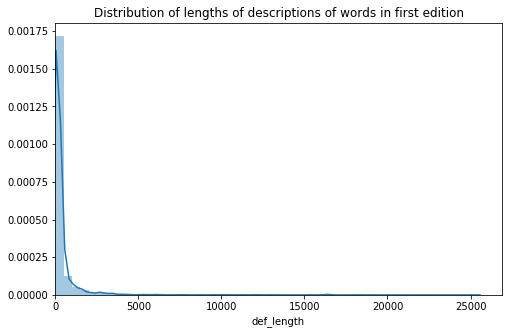

In [58]:
plt.figure(figsize=(8, 5))
chart = sns.distplot(first_ed_clean['def_length'])
chart.set_title('Distribution of lengths of definitions in first edition')
plt.xlim(0)
plt.show()

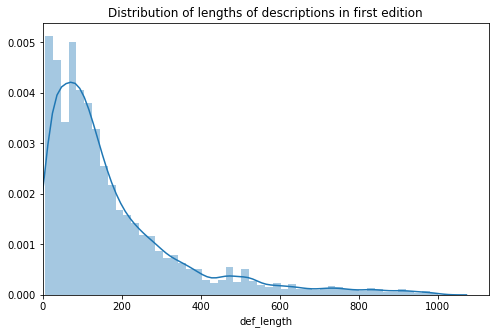

In [59]:
first_ed_short_descs = first_ed_clean.loc[first_ed_clean['def_length'] < 1000] # very large 

plt.figure(figsize=(8, 5))
chart = sns.distplot(first_ed_short_descs['def_length'])
chart.set_title('Distribution of lengths of definitions in first edition')
plt.xlim(0)
plt.show()

### Distribution of references to other entries in definitions

In [77]:
refs_in_desc = []

for index, row in first_ed_clean.iterrows():
    refs_in_desc.append(len(re.findall('See .*', row['definition'])))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,


In [81]:
first_ed_clean = first_ed_clean.assign(refs_in_desc=refs_in_desc)

In [83]:
first_ed_clean.describe()

,header_length,def_length,refs_in_desc
count,22318.000000,22318.000000,22318.000000
mean,6.179944,395.270096,0.222511
std,2.963667,1211.762172,0.469484
min,2.000000,6.000000,0.000000
25%,4.000000,67.000000,0.000000
50%,6.000000,132.000000,0.000000
75%,8.000000,282.000000,0.000000
max,22.000000,25084.000000,6.000000


In [88]:
first_ed_clean.loc[first_ed_clean['refs_in_desc'] > 5]

5357    in geometry, the ftraight line in a plain figu...
7865    in natural hiftory, properly denotes a\nlittle...
Name: definition, dtype: object

In [90]:
list(first_ed_clean.loc[first_ed_clean['headers'] == "CALCULUS"].definition)

['in natural hiftory, properly denotes a\nlittle ftone or pebble. See Pebble.\nCalculus, or calculus humanus, in medicine,\nthe ftone in the bladder or kidneys. See Medicine,\nand Surgery.\nCalculus alfo denotes a method of computation, fo\ncalled from the calculi, or counters, anciently ufed for\nthis purpofe. Hence,\nCalculus specialise or literalis, is the fame\nwith algebra. See Algebra.\nCalculus diffcrentialis is a method of differencing\nquantities, that is, of finding an infinitely fmall quan¬\ntity, which being taken an infinite number of times,\nfhall be equal to a given quantity. See Fluxions.\nCalculus among mathematicians, a me¬\nthod of differencing exponential quantities, and fum-\nming up the differentials of exponential quantities.\nSee Fluxions.\nCalculus integralis, or summatorius, is a me¬\nthod of fumming up differential quanties ; that is,\nfrom a differential quantity given, to find the quantity\nfrom whofe differencing the given differential refults.\nSee Fluxio

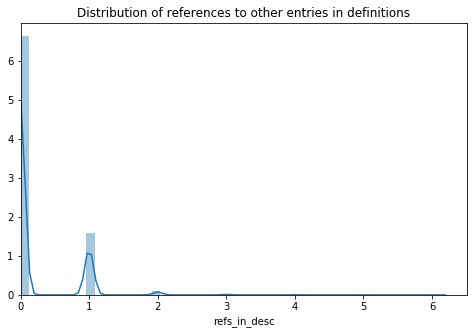

In [91]:
plt.figure(figsize=(8, 5))
chart = sns.distplot(first_ed_clean['refs_in_desc'])
chart.set_title('Distribution of references to other entries in definitions', )
plt.xlim(0)
plt.show()

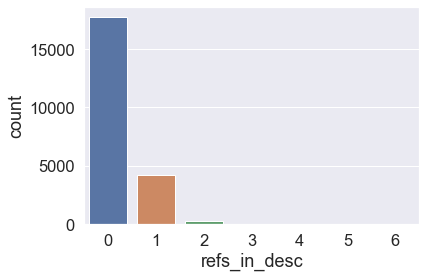

In [163]:
p = sns.countplot(x="refs_in_desc", data=first_ed_clean)

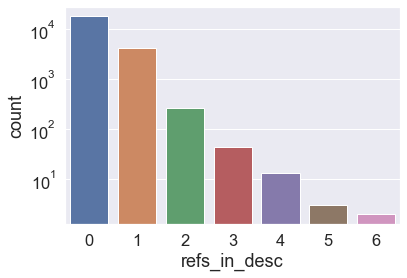

In [165]:
p = sns.countplot(x="refs_in_desc", data=first_ed_clean)
p.set_yscale("log")

In [ ]:
first_ed_clean[]

### Link between length of header and length of description

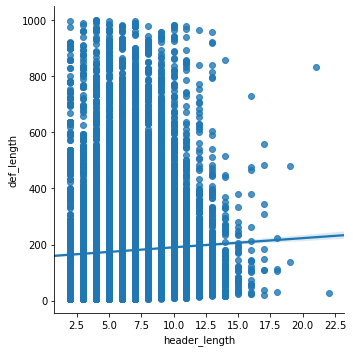

In [62]:
sns.lmplot( x="header_length", y="def_length", data=first_ed_short_descs)
plt.show()

### Most referenced entries

In [94]:
refs = []

for index, row in first_ed.iterrows():
    refs += re.findall('See .*', test_vol_clean) # stop selection at punctuation mark?
print(len(refs))
print(refs[:20])

4632
['See Zeus.', 'See Psittacus.', 'See Abacus.', 'See Bahama.', 'See plate I. fig. i. and', 'See plate I. fig. 2. A B,', 'See Calycanthus.', 'See Abased.', 'See Alienation.', 'See Ana¬', 'See Abate.', 'See Adansonta.', 'See Abeyance.', 'See Abbot.', 'See Abatis.', 'See Abrochment.', 'See Verbesina.', 'See Cucumis.', 'See Logic, and Propojition.', 'See Anatomy, part VI.']


In [101]:
all_refs = pd.DataFrame(refs)
print(all_refs[0].value_counts())

See Chemistry.                     33
See Astronomy.                     30
See Cyprinus.                      27
See the next article.              24
See Surgery.                       21
                                   ..
See Blare.                          3
See Art. »                          3
See Punica.                         3
See plate XI. fig.'2.               3
See Law, title. Supreme judges,     3
Name: 0, Length: 1299, dtype: int64


In [102]:
max(set(refs), key=refs.count)

'See Chemistry.'

In [132]:
all_refs.head()

,0
0,See Zeus.
1,See Psittacus.
2,See Abacus.
3,See Bahama.
4,See plate I. fig. i. and


In [139]:
popular_refs = all_refs[0].value_counts()
df_popular_refs = pd.DataFrame(popular_refs[:11])
df_popular_refs['references'] = df_popular_refs.index
df_popular_refs

,0,references
See Chemistry.,33,See Chemistry.
See Astronomy.,30,See Astronomy.
See Cyprinus.,27,See Cyprinus.
See the next article.,24,See the next article.
See Surgery.,21,See Surgery.
See Pneumatics.,21,See Pneumatics.
See Bos.,18,See Bos.
See Ana¬,18,See Ana¬
See Sparus.,18,See Sparus.
See Falco.,18,See Falco.


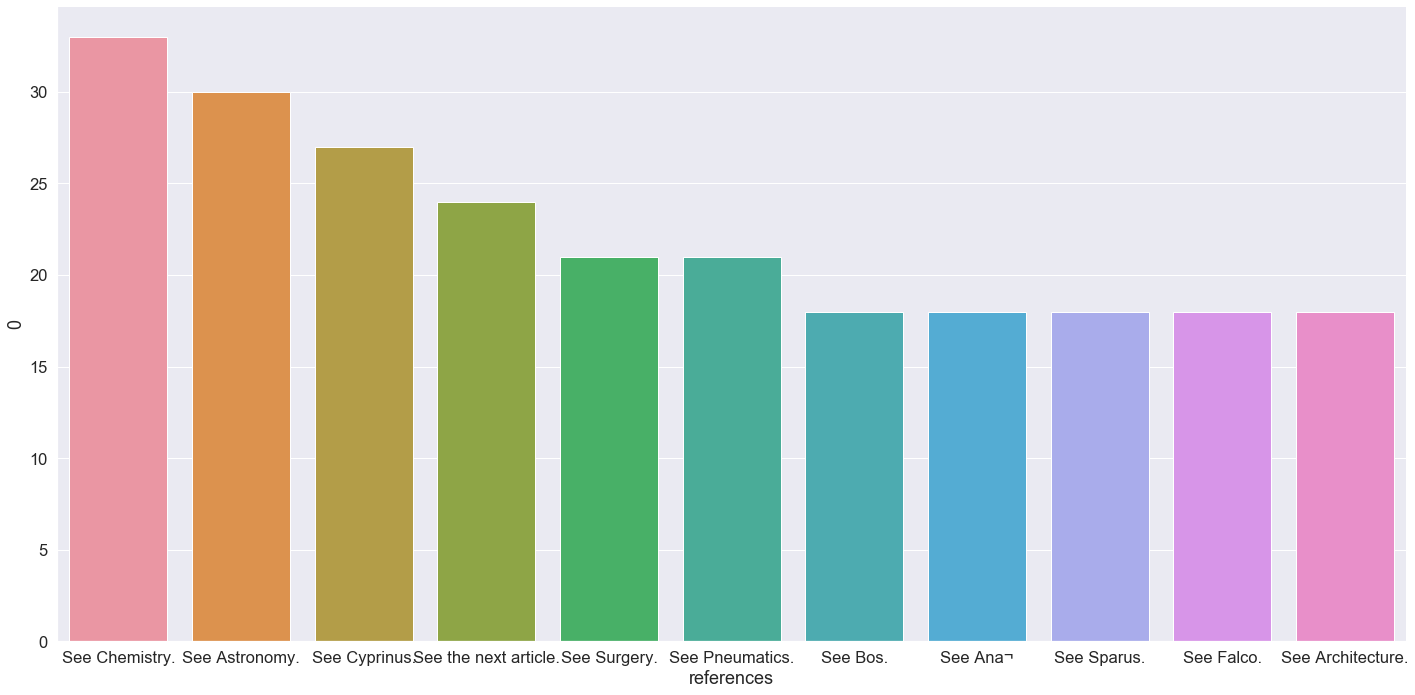

In [153]:
sns.set(font_scale=1.5)
sns.factorplot(x='references', y=0, data=df_popular_refs, kind='bar', size=10, aspect=2)
plt.show()

c:\users\vaida\github\library\env\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


ValueError: Input data must be a pandas object to reorder

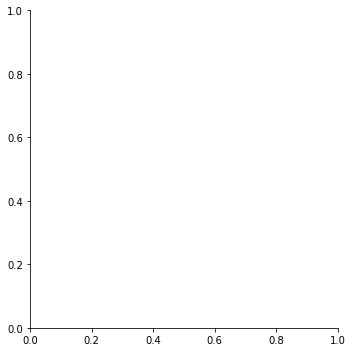

In [124]:
sns.factorplot(data=popular_refs[:10], kind='bar')  

In [112]:
fig, ax = plt.subplots()
all_refs[0].value_counts().plot(ax=ax, kind='bar')

Error in callback <function flush_figures at 0x12AC2AE0> (for post_execute):


KeyboardInterrupt: 

In [207]:
list(heads.loc[heads['headers'] == 'LAW'].definitions) # are there definitions for composed words? eg martial law?

[' See By-laws.\n',
 'among zoologifts, denotes the (harp-pointed\nnails with which the feet of ceitain quadrupeds and\nbirds are furnifhed.\nCrab’s Claws, in pharmacy, See Crab’s claws.\n',
 'among zoologifts, denotes the (harp-pointed\nnails with which the feet of ceitain quadrupeds and\nbirds are furnifhed.\nCrab’s Claws, in pharmacy, See Crab’s claws.\n',
 'is the law of war, which entirely de¬\npends on the arbitrary power of the prince, or of thofe\nto whom he has delegated it. For though the king\ncan make no laws in time of peace without the confent\nof parliament, yet in time of war he ufes an abfolute\npo - er over the army\n']

In [199]:
list(heads.loc[heads['headers'] == 'ANALOGY'].definitions)

['in matters of literature, a certain relation\nand agreement between two or more things, which in\nother refpefts are entirely different.\n.There is likewife an analogy between beings that\nhave fome conformity or refemblance to one another;\nfor example, between animals and plants ; but the\nanalogy is ftill ftronger between two different fpecies\nof certain animals.\nAnalogy enters much into all our reafoning, and\nferves to explain and illuflrate. A great part of our\nphilofophy has no other foundation than analogy, the\nutility of which confifts in foperfeding all rieceffity of\nexamining minutely every particular body; for it fuf-\nfices us to know that every thing is governed by gene¬\nral and immutable laws, in order to regulate our con-\ndu£t with regard to all fimilar bodies, as we may rea-\nfonably believe that they are all endowed with the\nfame properties: Thus, we never doubt that the fruit\nof the fame tree has the fame taftc.\nAnalogy, among geometricians, denotes a fon

In [193]:
first_ed_data[first_ed_data.headers.str.contains('\w+OGY')]

,headers,definition,header_length,def_length
724,ADENOLOGY,See Adenography.\n,9,17
962,AETIOLOGY,that branch of phyfic which afiigns the\ncaufe...,9,62
2174,AMPHIBOLOGY,"in grammar and rhetoric, a term\nufed to denot...",11,203
2288,ANAGOGY,"or Anagoge, among ecclefialtical writers,\nthe...",7,103
2304,ANALOGY,"in matters of literature, a certain relation\n...",7,1511
3106,ANDROGYNOUS,"in zoology, an appellation given to\nanimals w...",11,179
3395,ANTHOLOGY,"a difcourfe of flowers, or of beauti¬\nful paf...",9,163
3416,ANTHROPOLOGY,"a difeourfe upon human nature.\nAnthropology, ...",12,167
3456,ANTILOGY,"in matters of literature, an inconfiHency\nbet...",8,89
3598,APOLOGY,"a Greek term, literally importing an ex-\ncufe...",7,84


#################################################################

In [40]:
re.findall(r'\w+OGY', test_vol_clean) # vs ogy

['ADENOLOGY',
 'AETIOLOGY',
 'AMPHIBOLOGY',
 'ANAGOGY',
 'ANALOGY',
 'ANDROGY',
 'ANTHOLOGY',
 'ANTHROPOLOGY',
 'ANTILOGY',
 'APOLOGY',
 'ASTROLOGY',
 'BATEOLOGY',
 'MONOGY',
 'BRONTOLOGY']

#################################################################################

In [147]:
list(heads.loc[heads['headers'] == 'BRONTOLOGY'].definitions)

['enotes the do&rine of thunder, or an\nexplanation -of its caufes, phsenomena, <&c. together\nwith the prefages drawn from it. See Thunder, and\nElectricity.\n']

In [107]:
len([x for x in headers_first_ed if re.match('\w+OGY', x)])

46

In [108]:
len([x for x in headers_last_ed if re.match('\w+OGY', x)])

923

In [113]:
# pick a few of these topics and do a minor rather than header search for them?
# also, a lot of this could be due to OCR noise
# are there any that existed in first as minor topics? can tell if this is caused by OCR through that 
# => actually use the word frequency code from programmerhistorian to figure this out

In [109]:
set([x for x in headers_last_ed if re.match('\w+OGY', x)]) - set([x for x in headers_first_ed if re.match('\w+OGY', x)])

{'ARCHAEOLOGY',
 'BIOLOGY',
 'CARPOLOGY',
 'CHOLOGY',
 'CHRISTOLOGY',
 'CHTHYOLOGY',
 'CONCHOLOGY',
 'COSMOLOGY',
 'DACTYLOLOGY',
 'ENTOMOLOGY',
 'ERPETOLOGY',
 'ESTHIOLOGY',
 'ETHNOLOGY',
 'ETIOLOGY',
 'GEOLOGY',
 'HELMINTHOLOGY',
 'HERPETOLOGY',
 'HETEROGYNA',
 'HISTOLOGY',
 'ICHNOLOGY',
 'LITERARYCHRONOLOGY',
 'LITHOLOGY',
 'LOGY',
 'MARTYROLOGY',
 'METEOEOLOGY',
 'METEOROLOGY',
 'MINEEALOGY',
 'MINERALOGY',
 'NITHOLOGY',
 'NOSOLOGY',
 'ODONTOLOGY',
 'OLOGY',
 'OPHIOLOGY',
 'PALAEONTOLOGY',
 'PALEONTOLOGY',
 'PETROLOGY',
 'PHKENOLOGY',
 'PHRENOLOGY',
 'PSYCHOLOGY',
 'RHABDOLOGY',
 'ROLOGY',
 'SKELETOLOGY',
 'SOTERIOLOGY',
 'TERMINOLOGY',
 'THYOLOGY'}

In [96]:
[x for x in headers_last_ed if re.match('\w+OGY', x)] # write a ft that checks for differences

['ADENOLOGY',
 'AETIOLOGY',
 'AMPHIBOLOGY',
 'ANAGOGY',
 'ANALOGY',
 'ANDROGYNOUS',
 'ANTHOLOGY',
 'ANTHROPOLOGY',
 'ANTILOGY',
 'APOLOGY',
 'ASTROLOGY',
 'BATEOLOGY',
 'MONOGYNIA',
 'BRONTOLOGY',
 'CHRONOLOGY',
 'DOXOLOGY',
 'ELOGY',
 'ENTEROLOGY',
 'ETYMOLOGY',
 'EULOGY',
 'GENEALOGY',
 'ICHTHYOLOGY',
 'ARTYROLOGY',
 'MENOLOGY',
 'MYOLOGY',
 'MYTHOLOGY',
 'ONTOLOGY',
 'ORNITHOLOGY',
 'OSTEOLOGY',
 'PATHOLOGY',
 'PHILOLOGY',
 'PHYSIOLOGY',
 'PHYTOLOGY',
 'THEOLOGY',
 'THEOLOGY',
 'THEOLOGY',
 'THEOLOGY',
 'THEOLOGY',
 'THEOLOGY',
 'THEOLOGY',
 'THEOLOGY',
 'THEOLOGY',
 'SARCOLOGY',
 'TAUTOLOGY',
 'THEOLOGY',
 'ZOOLOGY',
 'LOGY',
 'THEOLOGY',
 'PHILOLOGY']

In [125]:
# re-run words for subset?

In [92]:
# want to work on first & last edition, and remove pref/list of authors and end?
# do i want to remove longform articles, or not worry rn?

In [159]:
sample = content[:10000]

In [ ]:
# saved for later

for match in re.finditer('ADENOLOGY', test_vol_clean):
    print( "%s: %s" % (match.start(), match.group(0)))
    # using match.start to find until def
    print(test_vol_clean[match.start():match.start()+200])

In [160]:
# Code adapted from https://programminghistorian.org/en/lessons/counting-frequencies

wordlist = sample.split()

wordfreq = []
for w in wordlist:
    wordfreq.append(wordlist.count(w))

print("String\n" + sample +"\n")
# print("List\n" + str(wordlist) + "\n")
# print("Frequencies\n" + str(wordfreq) + "\n")
print("Pairs\n" + str(list(zip(wordlist, wordfreq))))
print("\n")

counts_frame = pd.DataFrame(list(zip(wordlist, wordfreq)), 
               columns =['wordlist', 'wordfreq']) 
print(len(counts_frame))
counts_frame.drop_duplicates(subset ="wordlist", keep ='first', inplace = True) 
print(len(counts_frame))

String
i ! $* i $: iu^b '
n*s-f7^'v
L
i A
j J ^ /^^W/
; h:;^’
J
- }r-r£c9'&} "*— "
..^4-—>,
'I
■
.
,/.
■ -,... v V *•
C*?>7 y
<rw /U^v UJ~L ^ (txk^L j 1rvt*Xitj
$/i*4j/cJysx*£>Xb<. f^oLZ^^c^. % 'bvC JJ.
' }v*c CclU^K <77t .
yy*t4**2^t*-C{+r ^tXCe^vK &v»w
8/y: t^cCv-yt^yA. *-? ^v. •^GL* ftc*frt
* U^>. ‘
** a^yUf^yX ^
}tA£. yylrrCj? yu>t f\ ^^2!
ENCYCLOPEDIA BRITANNICA.
VOLUME the FIRST.
**■*
'
,T S :u -I >;j .1 M U a C V'
.
A
ARTS and SCIENCES,
COVI PILED UPON A NEW PLAN.
IN WHICH
The diferent Sciences and Arts are dioefted into
" O
diflinct Treatifes or Syitems;
AND
. The \irious Technic a lTerms, <&c. are explained as they occur
in the order of the Alphabet.
ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES.
fry a Society of GENTLEMEN in Scotland.
IN THREE VOLUME S.
VOL. I.
EDINBURGH:
Printed for A. Bell and C. Macearquhar;
Aid fold by C o l i n M a cf a r q.u h a r, at his Printing-office, N.coifon-HreeL
\l965r.
SCO,-
PREFACE
UTILITY ought to be the principal intention of every pub

In [161]:
counts_frame.loc[counts_frame['wordfreq'] > 3]

,wordlist,wordfreq
0,i,5
10,A,8
25,.,4
74,the,91
79,S,4
86,a,19
92,and,33
102,The,5
107,are,8
114,or,7


In [71]:
len(re.findall('tbe', 'this is tbe best tbe'))

2

In [69]:
re.search('tbe', content)

<_sre.SRE_Match object; span=(8827, 8830), match='tbe'>

In [74]:
len(re.findall('tbe', content))

27

In [201]:
re.findall('[A-Z][A-Z]+', clean_content[27000:])

['ABERRATION',
 'ABERRATION',
 'ABERYSWITH',
 'ABESTA',
 'ABESTON',
 'ABETTOR',
 'ABEVACUATION',
 'ABEX',
 'ABEYANCE',
 'ABHEL',
 'ABIB',
 'ABIDING',
 'ABIES',
 'ABIGEAT',
 'AB',
 'GEATUS',
 'ABIG',
 'ES',
 'ABILITY',
 'ABINGDON',
 'AB',
 'INTESTATE',
 'ABISHERING',
 'ABIT',
 'ABJURATION',
 'ABLAC',
 'ABLACTATION',
 'ABLACQUEATION',
 'ABLATIVE',
 'ABLAY',
 'ABLECTI',
 'ABLEGMINA',
 'ABLET',
 'ABLUENTS',
 'ABLUTION',
 'ABO',
 'ABOARD',
 'ABOLITION',
 'ABOLLA',
 'ABOMASUS',
 'ABOMINATION',
 'ABORIGINES',
 'ABORTION',
 'ABORTIVE',
 'ABOY',
 'ABRA',
 'ABRACADABRA',
 'ABRAHAM',
 'ABRAHAMITES',
 'ABRAMIS',
 'ABRASA',
 'ABRASION',
 'ABRAUM',
 'ABRASAX',
 'ABRAX',
 'ABREAST',
 'ABRENUNCIATION',
 'ABRIDGEMENT',
 'ABROBANIA',
 'ABROCHMENT',
 'ABROGATION',
 'ABROLKOS',
 'ABRON',
 'ABRONO',
 'ABROTANOIDES',
 'ABROTANOIDES',
 'ABROTANUM',
 'ABRUPTION',
 'ABRUS',
 'ABRUZZO',
 'ABSCEDENTIA',
 'ABSCESS',
 'ABSCHARON',
 'ABSCISSE',
 'ABSCISSION',
 'ABSCONSA',
 'ABSENCE',
 'ABSINTHIATED',
 'ABSINTHIUM',

In [199]:
re.split('([A-Z][A-Z]+)', clean_content[10000:30000]) # TODO would then to add each word and its definition to a dataframe
# remove preface/list of authors, as well as endnotes ("end of first volume") can check if found with regex

['e other in Dutch\nBrabant.\n',
 'AAHUS',
 ', a fmall town and diftrift in Weftphalia.\n',
 'AAM',
 ', a Dutch meafure for liquids, containing about\n63 lb. avoirdupoife.\nA ',
 'AM',
 ' A, a province in Barbary, very little known.\n',
 'AAR',
 ',, the name of two rivers, one in Weftphalia, and one\nin Switzerland, It is likewife the name of a fmall\nifland in the Baltic fea.\n',
 'AARSEO',
 ', a town inAfrica, fituated near the mouth of\nthe river Mina.\n',
 'AATTER',
 ", or At ter, a province of Arabia Felix, fi¬\ntuated on the Red-fea.—N. 'B. All other places which\nbegin with a double A, but more generally with.a\nAngle one, will be inferted according to the laft ortho¬\ngraphy.\n",
 'AB',
 ', the eleventh month of the civil year of the Hebrews.\nIt correfponds to part of our June and July, and con-\nfifts of 30 days. On the firfi of this month the Jews\ncommemorate the death of Aaron by a fall: they fall\nalfo on the ninth, becaufe on that day both the temple\nof Solomon and that